# Imputation of association statistics in GWAS

## Background

In a traditional GWAS, one collects genotype data at a small subset of SNPs over some individuals, then imputes genotypes across the entire genome, and finally computes association statistics (e.g. Z-scores) for each genotyped and imputed SNPs. This procedure can take tremendous amount of time as genotype imputation is computationally extensive.

Here, we impute Z-scores of ungenotyped SNPs directly from Z-scores of genotyped SNPs, without first performing genotype imputation, saving hundreds of hours of CPU time. The idea behind this approach is that Z-scores of genotyped and ungenotyped SNPs follow a multivariate normal distribution with LD matrix, which can be estimated from a reference panel, as the covariance structure -- one can impute the Z-scores of ungenotyped SNPs as the expectation of Z-scores of ungenotyped SNPs conditional on the Z-scores of genotyped SNPs.

In detail, let $Z = (Z_t, Z_u)$ be the Z-score vector partitioned into two components, genotyped ($Z_t$) and ungenotyped ($Z_u$). It has been previously shown that $Z$ has the following distribution,
$$
\left[
\begin{array}{c}
Z_t \\
Z_u
\end{array}
\right]
\sim
MVN
\left(
\left[
\begin{array}{c}
\Lambda_t \\
\Lambda_u
\end{array}
\right]
,
\left[
\begin{array}{cc}
\Sigma_{tt} & \Sigma_{tu}\\
\Sigma_{ut} & \Sigma_{uu}
\end{array}
\right]
\right),
$$
where $\Lambda = (\Lambda_t, \Lambda_u)$ is the non-centrality parameter, $\Sigma_{tt}$ the LD between genotyped SNPs, $\Sigma_{tu}$ the LD between genotyped and ungenotyped SNPs, $\Sigma_{uu}$ the LD between ungenotyped SNPs.

The conditional expectation of $Z_u$ given $Z_t$ is then
$$
Z_u | Z_t
\sim
MVN
\left(
\Lambda_u + \Sigma_{ut} \Sigma^{-1}_{tt} Z_t
,
\Sigma_{uu} - \Sigma_{ut} \Sigma^{-1}_{tt} \Sigma_{tu}
\right).
$$

We impute the Z-scores of ungenotyped SNPs as $\hat{Z}_u = E[Z_u | Z_t] = \Sigma_{ut} \Sigma^{-1}_{tt} Z_t$ under the null assumption that $\Lambda_u = 0$. Let $W = \Sigma_{ut} \Sigma^{-1}_{tt}$. This can be viewed as the weights on Z-scores of genotyped SNPs in the imputation of Z-scores of ungenotyped SNPs. Then 
$$
\hat{Z}_u \sim MVN (0, \Sigma_{ut} \Sigma^{-1}_{tt} \Sigma_{tu}),
$$
where each entry $\hat{Z}_{u,i}$ of $\hat{Z}_u$ follows
$$
\hat{Z}_{u,i} \sim N (0, \Sigma_{ut,i*} \Sigma^{-1}_{tt} \Sigma_{tu,*i}).
$$
Here, $\Sigma_{ut,i*}$ denotes the $i$-th row of $\Sigma_{ut}$ and $\Sigma_{tu,*i}$ the $i$-th column of $\Sigma_{tu}$. To obtain a associations statistics that has mean 0 and variance 1, we standardize $\hat{Z}_{u,i}$ by $\sqrt{\Sigma_{ut,i*} \Sigma^{-1}_{tt} \Sigma_{tu,*i}}$. More specifically, the final imputated association statistics of each SNP is
$$
\hat{Z}_{imp,i} = {\hat{Z}_{u,i} \over \sqrt{\Sigma_{ut,i*} \Sigma^{-1}_{tt} \Sigma_{tu,*i}}}
\sim N(0, 1).
$$

In practice, inverting a large matrix can be time-consuming. Instead, we adopt a window-based approach, i.e. we impute Z-scores of ungenotyped SNPs one window at a time.

# Example

In [1]:
# load in required packages
include("../src/ImputeZScore.jl")
using DataFrames, .ImputeZScore, SnpArrays

In [2]:
# read in z-scores of genotyped SNPs on chromosome 22 as a data frame
zsc_t = readtable("./hdl_chr22_typed.zsc", separator=' ')

,rsID,pos,A0,A1,Z
1,rs5746647,17057138,G,T,1.9927
2,rs5747968,17067504,G,T,3.07937
3,rs2236639,17072483,A,G,2.16346
4,rs5746679,17080378,A,G,2.58537
5,rs11089263,17087656,C,A,0.5
6,rs2096537,17094749,A,C,-0.291139
7,rs4819849,17152611,A,G,2.12903
8,rs2845379,17202602,T,C,-0.0188679
9,rs2845346,17214252,C,T,-0.144928
10,rs1807512,17221495,T,C,0.190476


In [3]:
# there are only 3000 genotyped SNPs
println(size(zsc_t))

(3000,5)


In [4]:
# read in reference panel from 1000 genomes project for chromosome 22
refpanel = SnpData("./1000G.EUR.22");

In [5]:
# the reference panel has 17,489 SNPs on chromosome 22
println(size(refpanel.snpmatrix))

(489,17489)


In [6]:
# perform imputation using the method described above
# this will take less than 20 seconds
@time zsc_imp = impute_zscore(zsc_t, refpanel)

 12.159418 seconds (56.25 M allocations: 1.758 GB, 3.29% gc time)


,rsID,pos,A0,A1,Z,r2pred
1,rs2379981,17030792,G,A,1.92311081771678,0.7058953255506147
2,rs4535153,17031072,C,T,1.92311081771678,0.7058953255506147
3,rs9605903,17054720,C,T,2.0701431882270103,0.7408140292495196
4,rs5747988,17073066,A,G,2.1420214615367983,0.8888470136086104
5,rs5746664,17074622,A,C,2.2380129833458775,0.9145446940729179
6,rs2070501,17084609,A,G,0.345275873016319,0.9150176620818633
7,rs16984366,17096864,C,T,-1.9453553255953884,0.7214178549189546
8,rs8137637,17103717,G,T,-1.9810206754861308,0.7292560905519018
9,rs4410381,17107266,A,G,-2.103212138721683,0.7331804789915228
10,rs5993671,17116398,G,T,-0.24647770341008562,0.8940490578545027


In [7]:
# the imputed data set has much more SNPs
# the last column r2pred is a measure of imputation accuracy
# note that this module filters out poorly imputed SNPs (r2pred < 0.6) by default
println(size(zsc_imp))

(10268,6)


In [8]:
# now let's compare the imputed z-scores with the z-scores obtained by first
# performing a genotype imputation
zsc_full = readtable("./hdl_chr22_full.zsc", separator=' ');

# this removes SNPs with duplicated SNP ID and position and makes the
# sign consistent
snp_legend = DataFrame(rsID = refpanel.snpid, pos = refpanel.basepairs,
    A0 = refpanel.allele1, A1 = refpanel.allele2)
filter_input!(zsc_full, snp_legend)

In [9]:
# match z-scores based on SNP ID
zsc_matched = join(zsc_full, zsc_imp, on=:rsID)
println(zsc_matched)

7444×10 DataFrames.DataFrame
│ Row  │ rsID        │ pos      │ A0  │ A1  │ Z          │ pos_1    │ A0_1 │
├──────┼─────────────┼──────────┼─────┼─────┼────────────┼──────────┼──────┤
│ 1    │ "rs1000427" │ 36890105 │ "G" │ "A" │ -0.697368  │ 36890105 │ "A"  │
│ 2    │ "rs1000815" │ 26831077 │ "A" │ "G" │ 0.166667   │ 26831077 │ "A"  │
│ 3    │ "rs1001021" │ 26403599 │ "G" │ "A" │ -0.290598  │ 26403599 │ "A"  │
│ 4    │ "rs1001213" │ 34131736 │ "G" │ "A" │ 1.66346    │ 34131736 │ "A"  │
│ 5    │ "rs1001586" │ 42670293 │ "G" │ "T" │ 0.516667   │ 42670293 │ "T"  │
│ 6    │ "rs1001587" │ 42670111 │ "C" │ "T" │ 0.516667   │ 42670111 │ "T"  │
│ 7    │ "rs1001794" │ 32850930 │ "C" │ "T" │ -0.163636  │ 32850930 │ "T"  │
│ 8    │ "rs1001896" │ 19032215 │ "G" │ "A" │ -0.580645  │ 19032215 │ "A"  │
│ 9    │ "rs1002048" │ 34253393 │ "G" │ "T" │ 1.2        │ 34253393 │ "G"  │
│ 10   │ "rs1002189" │ 30771458 │ "T" │ "C" │ -1.69643   │ 30771458 │ "C"  │
│ 11   │ "rs1003480" │ 31346752 │ "A" │ "G" │ -

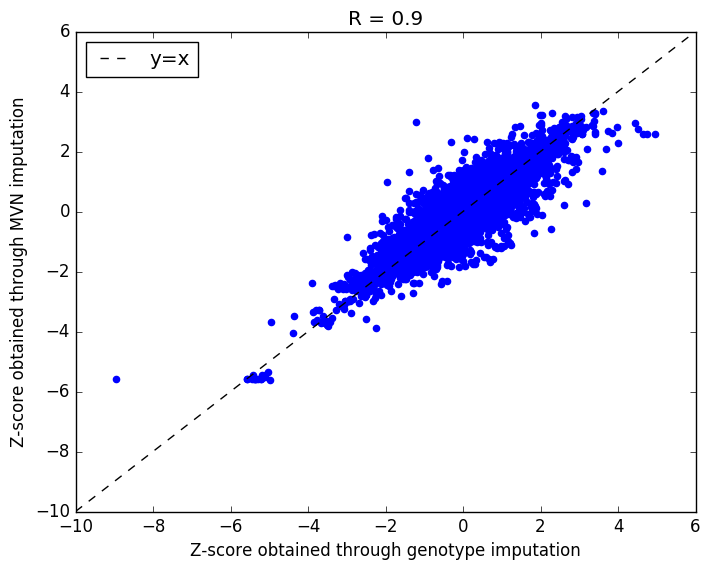

PyObject <matplotlib.text.Text object at 0x7f90ed6fbbd0>

In [11]:
# make scatter plot comparing the z-scores obtained through different methods
using PyPlot
scatter(zsc_matched[:Z], zsc_matched[:Z_1], color="blue")
plot([-10, 6], [-10, 6], color="black", linestyle="--", label="y=x")
legend(loc=2)
xlim([-10, 6]); ylim([-10, 6])
xlabel("Z-score obtained through genotype imputation")
ylabel("Z-score obtained through MVN imputation")
title("R = " * string(round(cor(zsc_matched[:Z], zsc_matched[:Z_1]),2)))